In [10]:
#Import the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import pickle
import json

#Import the dataset
import os
df = pd.read_csv("household-energy.csv")
df

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625
...,...,...,...,...,...,...,...,...,...,...
995,3,0,991.31,0,1,0,12687.26,1,1,655.870111
996,2,5,847.97,0,1,0,39502.92,0,0,354.472693
997,2,4,660.94,1,0,0,10145.17,0,1,568.660550
998,1,1,814.75,0,1,1,15535.05,0,1,653.423314


The dataset contains 1000 rows and 10 columns.

These are the columns and the type of data they contain:
num_rooms               int64
num_people              int64
housearea             float64
is_ac                   int64
is_tv                   int64
is_flat                 int64
ave_monthly_income    float64
num_children            int64
is_urban                int64
amount_paid           float64
dtype: object


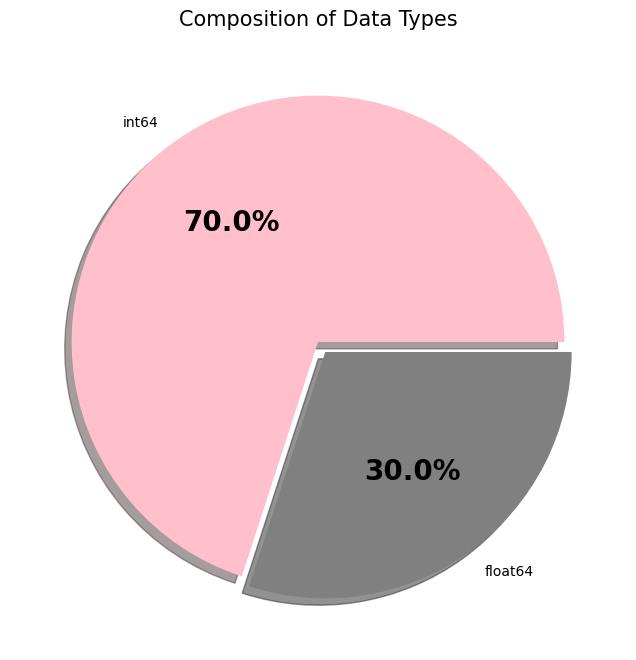

In [11]:
#Look into the size of the dataset
print('The dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

#Describe the type of columns
print('\nThese are the columns and the type of data they contain:')
print(df.dtypes)

#To visualize the percentage I create a pie chart
freq = Counter(list(df.dtypes))
freq = pd.DataFrame.from_dict(freq, orient='index')

fig, ax = plt.subplots(figsize = (8, 8))
_, _, freq_pie = plt.pie(freq[0], labels = ['int64', 'float64'], colors = ['pink', 'grey'],
                         explode = [0, .05], shadow = True, autopct='%1.1f%%')
plt.setp(freq_pie, **{'color' : 'black', 'weight':'bold', 'fontsize' : 20})
plt.title('Composition of Data Types', fontsize = 15)
plt.show()

In [7]:
df.describe()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.962000,4.897000,794.703420,0.376000,0.798000,0.477000,24684.986550,1.078000,0.608000,600.396359
std,1.030348,2.007591,147.771736,0.484622,0.401693,0.499721,9678.228224,0.934232,0.488441,181.406210
min,-1.000000,-1.000000,244.400000,0.000000,0.000000,0.000000,-1576.440000,0.000000,0.000000,87.851850
25%,1.000000,4.000000,691.037500,0.000000,1.000000,0.000000,18036.762500,0.000000,0.000000,475.065141
50%,2.000000,5.000000,789.970000,0.000000,1.000000,0.000000,24742.575000,1.000000,1.000000,598.331726
75%,3.000000,6.000000,892.955000,1.000000,1.000000,1.000000,31402.357500,2.000000,1.000000,729.930489
max,5.000000,11.000000,1189.120000,1.000000,1.000000,1.000000,56531.080000,4.000000,1.000000,1102.994109


/var/folders/qv/50wj51b55gn5gfwh7t0pfkq80000gn/T/ipykernel_1504/3581795719.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


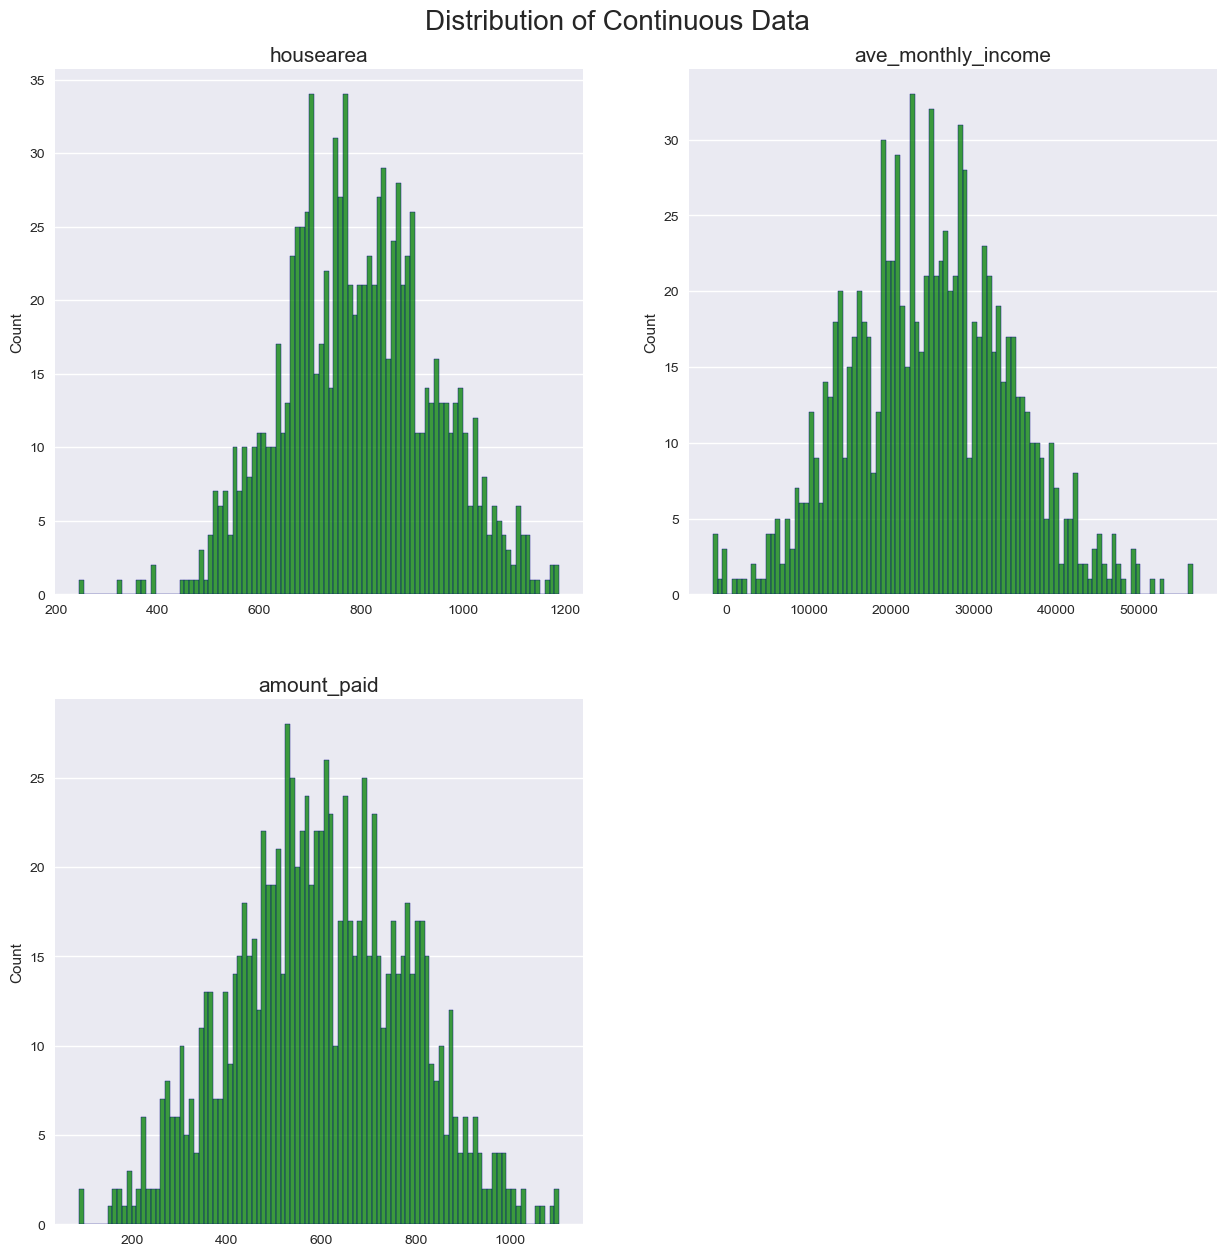

In [12]:
#Separate the continuous columns first
numeric_flag = []
for col in df.columns:
    numeric_flag.append(df[col].dtypes == 'float64')
df_numeric_column = df.columns[numeric_flag]

#Create the histograms
plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
axes[1][1].remove()

i = 0
for ax_group in axes:
    for axis in ax_group:
        if i == 3:
            continue
        else:
            sns.histplot(df[df_numeric_column[i]], bins = 100, ax = axis, color = 'green', edgecolor = 'navy')
            axis.set_xlabel('')
            axis.grid(axis = 'x')
            axis.set_title(df_numeric_column[i], fontsize = 15)
        i = i+1
plt.suptitle('Distribution of Continuous Data', fontsize = 20, y = .92)
plt.show()

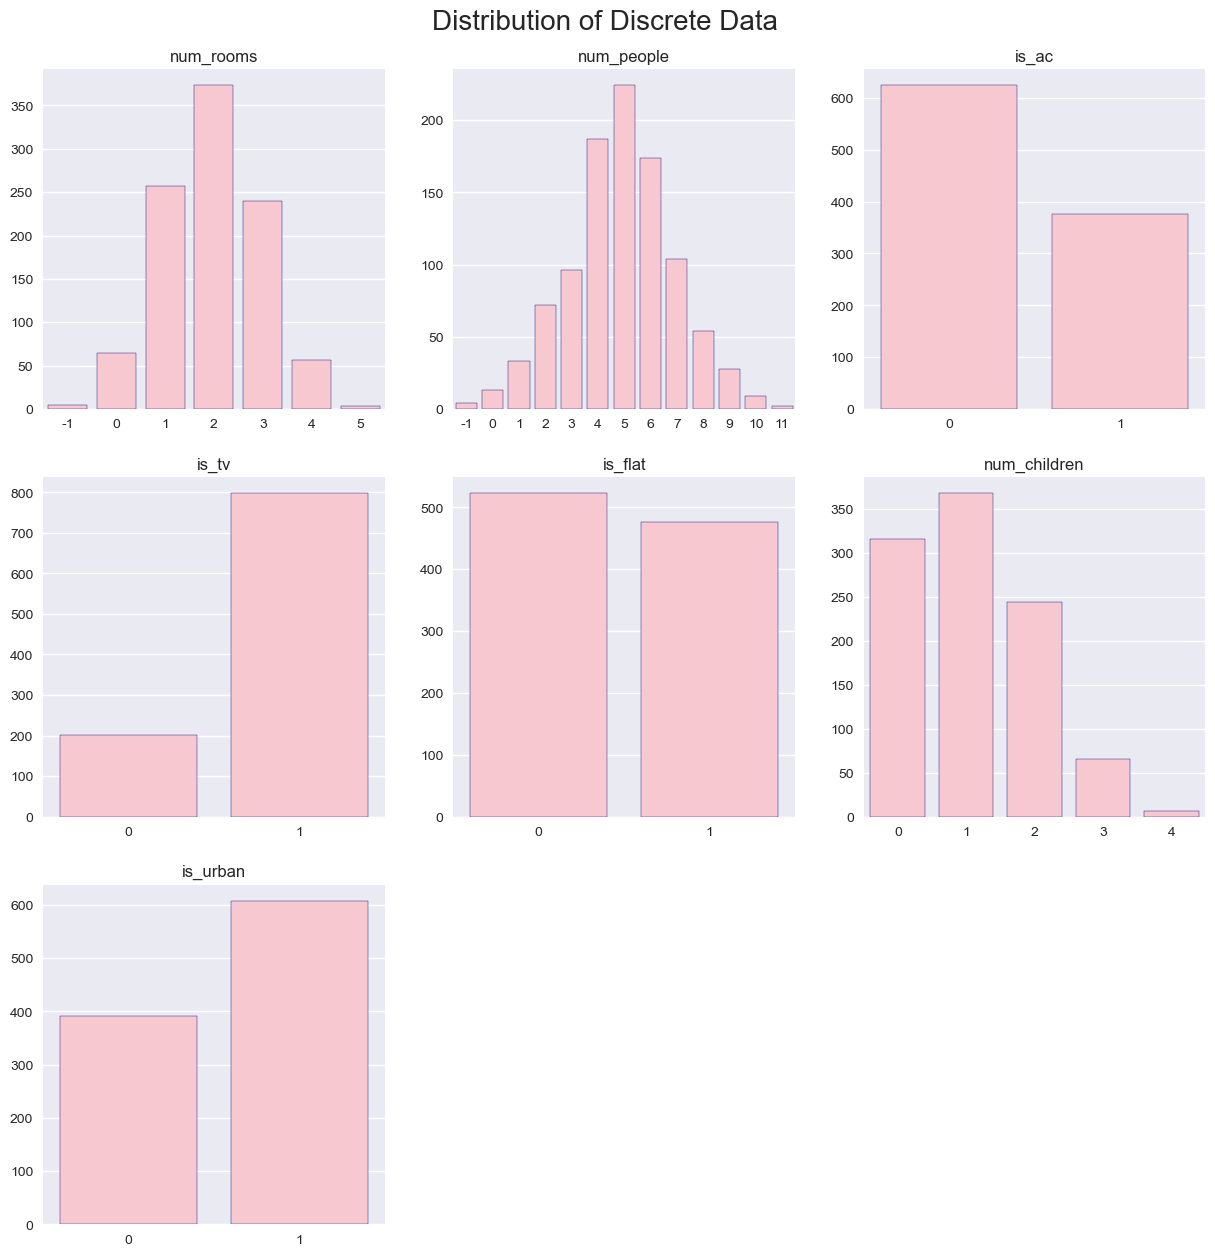

In [25]:
#Take the discrete columns, which are all the other ones
discrete_data = [not x for x in is_numeric]
df_discrete = df.columns[discrete_data]

#Create the histograms
fig, axes = plt.subplots(3, 3, figsize = (15,15))
axes[2][1].remove()
axes[2][2].remove()

i = 0
j = 0
for col in df_discrete:
    unique_values = df[col].unique()
    unique_values.sort()
    count_unique = []
    
    for values in unique_values:
        count_unique.append((df[col] == values).sum())
    
    sns.barplot(x = unique_values, y = count_unique, ax = axes[j][i], color = 'pink', edgecolor = 'navy')
    axes[j][i].set_title(col)
    
    if i == 2:
        j = j + 1
        i = 0
    else:
        i = i + 1
plt.suptitle('Distribution of Discrete Data', fontsize = 20, y = .92)
plt.show()

In [4]:
#Create a list of the columns that will need to be transformed
scale_columns = ['num_rooms', 'num_people', 'housearea', 'ave_monthly_income', 'num_children']
df[scale_columns].head()

,num_rooms,num_people,housearea,ave_monthly_income,num_children
0,3,3,742.57,9675.93,2
1,1,5,952.99,35064.79,1
2,3,1,761.44,22292.44,0
3,0,5,861.32,12139.08,0
4,1,8,731.61,17230.10,2


In [5]:
#Create the scaler
scaler = StandardScaler()

#Scale the columns previously selected and replace them in the dataset
df[scale_columns] = scaler.fit_transform(df[scale_columns])
df.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,1.007930,-0.945386,-0.352973,1,1,1,-1.551582,0.987401,0,560.481447
1,-0.934132,0.051331,1.071692,0,1,0,1.073027,-0.083533,1,633.283679
2,1.007930,-1.942104,-0.225213,1,1,1,-0.247333,-1.154467,0,511.879157
3,-1.905163,0.051331,0.451033,1,1,0,-1.296951,-1.154467,0,332.992035
4,-0.934132,1.546407,-0.427179,0,1,0,-0.770659,0.987401,1,658.285625


In [13]:
#Select all the columns except the last one as features
x = df.iloc[:, :9]

#Select amount_paid as the target variable
y = df['amount_paid']

#The train set will have 80% of the data and the other 20% will be for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 9)

In [14]:
scores = pd.DataFrame(columns = ['Random Search', 'Grid Search'])

In [15]:
#Ordinary least squares Linear Regression.
#Create the estimator
model_LR = LinearRegression()

#Train the model
model_LR.fit(x_train,y_train)

#Create predictions based on the test set
y_pred = model_LR.predict(x_test)

#Evaluate the predictions with the coefficient of determination (R^2)
results_linear = r2_score(y_test, y_pred)

#Store the scores
scores = scores.append({'Random Search' : results_linear, 'Grid Search' : results_linear},
                       ignore_index = True)

/var/folders/qv/50wj51b55gn5gfwh7t0pfkq80000gn/T/ipykernel_1504/1294681741.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_linear, 'Grid Search' : results_linear},


In [16]:
results_linear

0.8727898074185138

In [17]:
scores

,Random Search,Grid Search
0,0.87279,0.87279


In [18]:
#Create the estimators with the best parameters
Linear_final = LinearRegression()

#Train the models using the train data
Linear_final.fit(x_train, y_train)

#Create prediction values using the test data
Linear_predict = Linear_final.predict(x_test)

#Evaluate the predictions with R^2
Linear_score = r2_score(y_test, Linear_predict)

#Group the scores and the model names
bar_x = ['Linear']
bar_y = [Linear_score * 100]

print('Prediction score from LinearRegression alogrithm is',bar_y)

Prediction score from LinearRegression alogrithm is [87.27898074185137]


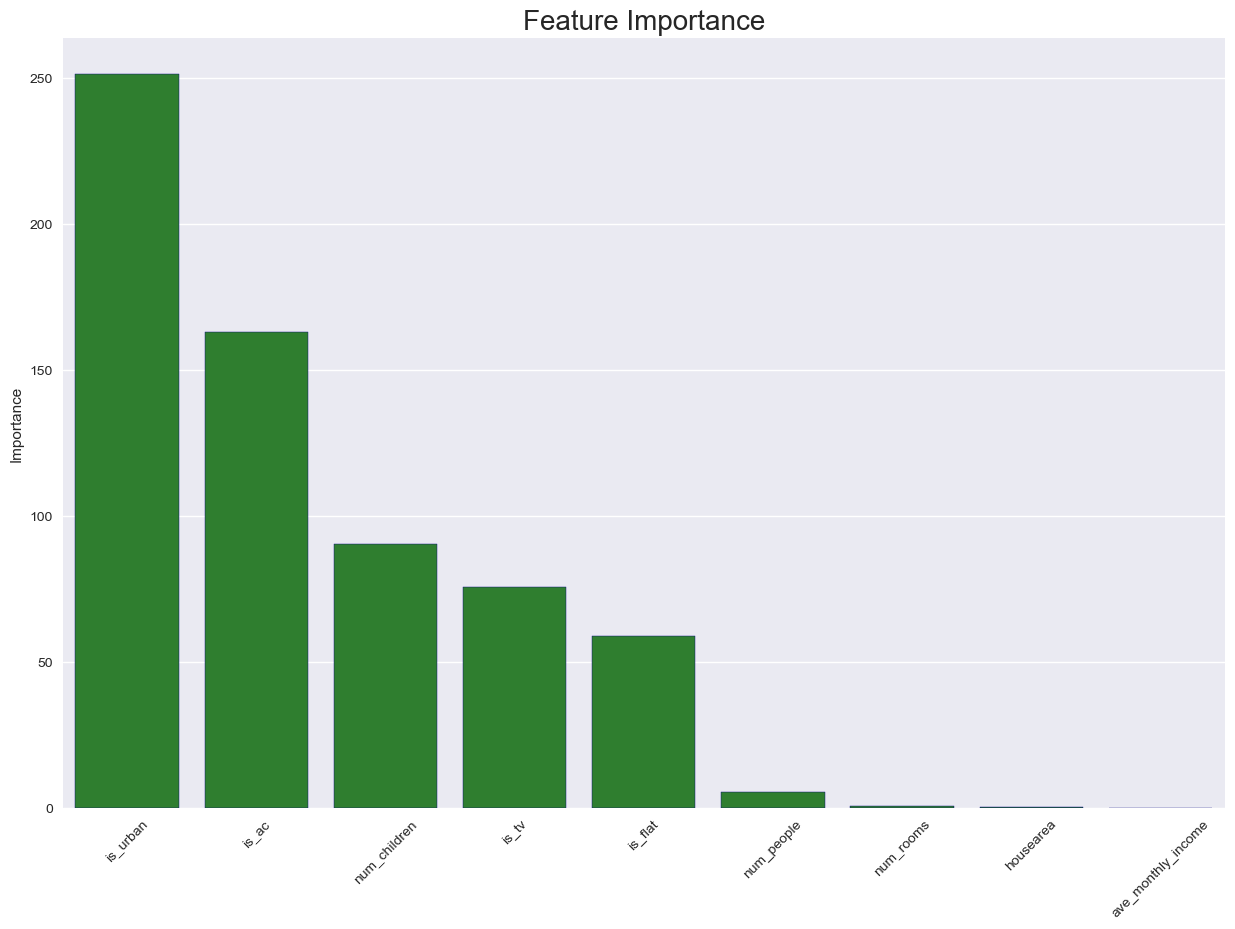

In [19]:
#Access the feature coefficients from the trained model and get the absolute value
importance = Linear_final.coef_
importance = np.abs(importance)

#Create a Dataframe of each feature and its importance
feature_importance = pd.DataFrame(list(zip(x_train.columns, importance)),
                                 columns = ['Feature', 'Importance'])

#Sort Dataframe by Importance in descending order
feature_importance = feature_importance.sort_values('Importance',
                                                    ascending = False).reset_index(drop = True)

#Create a bar plot
plt.figure(figsize = (15, 10))
sns.barplot(x = feature_importance['Feature'], y = feature_importance['Importance'], color = 'forestgreen', edgecolor = 'navy')
plt.xticks(rotation = 45)
plt.xlabel('')
plt.title('Feature Importance', fontsize = 20)
plt.show()

In [20]:
df.iloc[313]

num_rooms                 3.00000
num_people                8.00000
housearea               631.54000
is_ac                     0.00000
is_tv                     1.00000
is_flat                   1.00000
ave_monthly_income    12107.02000
num_children              1.00000
is_urban                  1.00000
amount_paid             756.08723
Name: 313, dtype: float64

In [21]:
df.columns

Index(['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban', 'amount_paid'],
      dtype='object')

In [22]:
X = df.drop('amount_paid', axis=1)
y = df['amount_paid']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 9)

In [33]:
y_train

981    659.070221
829    760.384842
634    300.433545
97     302.491207
836    708.022855
          ...    
950    815.168775
501    475.007826
638    353.266606
348    357.784461
382    795.494744
Name: amount_paid, Length: 800, dtype: float64

In [36]:
clf = LinearRegression()
clf.fit(X_train.values, y_train)

LinearRegression()

In [38]:
y_pred_train = clf.predict(X_train.values)
y_pred = clf.predict(X_test.values)

print(y_pred)

[ 471.00050439  869.08088675  528.41030134  780.08373241  545.84877101
  671.92512482  648.77126279  768.56362663  657.17912552  787.25235496
  740.52805882  641.79421861  300.91429054  588.37567625  524.37291527
  623.06508081  761.95221313  648.1065038   268.44343497  545.18377045
  449.33790887  613.9279194   633.77436752  401.29982299  288.16105197
  220.58962645  684.79677853  687.71071728  811.19685291  859.92893277
  448.8423097   509.17014525  668.94711922  258.13724347  468.06633884
  447.58937241  536.16845381  306.53302899  554.35411794  530.98002754
  353.81007943  621.51885205  549.90440276  528.68782646  438.18619806
  874.10056655  753.39521653  836.39521189  456.33090857  683.23754814
  505.38186448  627.67840249  705.75547008  616.9805445   368.39329146
  473.35188198  295.33900444  679.41241937  614.9609601   414.80800857
  704.3121017   609.93548308  415.25143775  422.40046675  572.83752894
  716.42344813  421.85016314  376.08265908  536.23386357  379.81947505
  340.

In [40]:
import pickle
pickle.dump(clf, open('model.pkl', 'wb'))